In [28]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from nzshm_common.location.location import LOCATIONS_BY_ID


In [29]:
nz_outline = '/home/chrisdc/NSHM/DEV/scripts/Data/nz-polygons'
nz_outline = gpd.read_file(nz_outline)

In [30]:
hazard_data = '/home/chrisdc/NSHM/oqresults/TAG_final/data/FullLT_allIMT_nz34_all_aggregates.json'
dtype = {'lat':str,'lon':str}
hazard_data = pd.read_json(hazard_data,dtype=dtype)

vs30 = 400

In [31]:
sites = pd.DataFrame()
for loc in LOCATIONS_BY_ID.values():
    idx = (hazard_data['lat'].astype('float')==loc['latitude'])&(hazard_data['lon'].astype('float')==loc['longitude'])
    hazard_data.loc[idx,'name'] = loc['name']
    sites.loc[loc['name'],['latitude','longitude']] = [loc['latitude'],loc['longitude']]

In [32]:
imt = 'SA(0.5)'
rp = 500
poe = 1/rp

index=np.unique(hazard_data['agg'])
imts = np.unique(hazard_data['imt'])
columns=pd.MultiIndex.from_product([sites.index, imts])
df = pd.DataFrame(index=index,columns=columns)

for imt in [imt]:
    for site in sites.index:
        for agg in np.unique(hazard_data['agg']):
            site_idx = hazard_data['name']==site
            imt_idx = hazard_data['imt']==imt
            agg_idx = hazard_data['agg']==agg
            idx = site_idx & imt_idx & agg_idx
            hcurve = hazard_data[idx][['level','hazard']].to_numpy()
            df.loc[agg,(site,imt)] = np.exp(np.interp(np.log(poe),np.log(np.flip(hcurve[:,1])),np.log(np.flip(hcurve[:,0]))))

cdf_idx = df.index[:-1]

In [33]:
cdf = np.array([float(x) for x in cdf_idx.values])
pdf = cdf[1:]-cdf[:-1]
pdf = (np.insert(pdf,0,0)+np.append(pdf,0))/2

site_im_distributions = pd.DataFrame(index=sites.index)
for site in sites.index:   
    ims = df.loc[cdf_idx,(site,imt)].astype('float').values
    expanded_ims = np.repeat(ims,(pdf*10000).astype(int))
    [alpha,beta,loc,scale] = stats.beta.fit(expanded_ims)
    
    site_im_distributions.loc[site,['alpha','beta','loc','scale']] = [alpha,beta,loc,scale]
    site_im_distributions.loc[site,['median']] = df.loc['0.5',(site,imt)].astype('float')
    site_im_distributions.loc[site,['min','max']] = [ims.min(),ims.max()]
    
    mean = stats.beta.mean(alpha,beta,loc,scale)
    std = stats.beta.std(alpha,beta,loc,scale)
    site_im_distributions.loc[site,['mean','std','cov']] = [mean, std, std/mean]  
    
gdf = gpd.GeoDataFrame(site_im_distributions,geometry=gpd.points_from_xy(sites.longitude,sites.latitude)).set_crs(epsg=4326)

/home/chrisdc/.virtualenvs/test_oq_reports/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [34]:
print(gdf)

                     alpha          beta       loc         scale    median  \
Auckland          2.609834  3.101398e+00  0.113647  4.026697e-01  0.291567   
Blenheim          2.729366  4.010909e+00  0.573151  1.851426e+00  1.291623   
Christchurch      1.812310  4.501237e+00  0.342868  1.243746e+00  0.662247   
Dunedin           1.911584  4.356016e+00  0.191756  7.094599e-01  0.390033   
Gisborne          3.486491  6.229426e+00  0.455470  2.080609e+00  1.190448   
Greymouth         2.378773  4.600477e+01  0.356634  9.081528e+00  0.731124   
Hawera            1.895657  2.022097e+00  0.269057  7.184094e-01  0.625351   
Hamilton          1.894845  2.060396e+00  0.187171  5.371772e-01  0.437197   
Invercargill      2.147154  3.196517e+00  0.284430  7.171107e-01  0.548617   
Kaikoura          2.676647  5.841031e+00  0.593285  2.296183e+00  1.257154   
Kerikeri          1.684786  3.194292e+00  0.074258  2.977045e-01  0.170048   
Levin             2.708852  4.805917e+00  0.572208  2.349347e+00

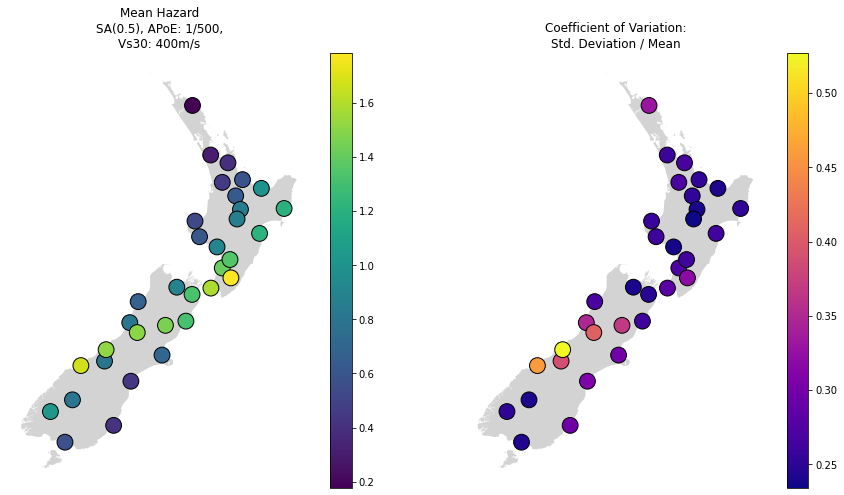

In [35]:
figsize = (15,8)
fig,ax = plt.subplots(1,2,figsize=figsize)
markersize=250

for i_metric,metric in enumerate(['mean','cov']):
    if metric=='mean':
        title = f'Mean Hazard\n{imt}, APoE: 1/{rp},\nVs30: {vs30}m/s'
    else:
        title = 'Coefficient of Variation:\nStd. Deviation / Mean'
    cmap = ['viridis','plasma'][i_metric]
    _ = nz_outline.plot(ax=ax[i_metric],color='lightgray')
    _ = gdf.plot(ax=ax[i_metric],column=metric,markersize=markersize,cmap=cmap,edgecolor='k',legend=True)
    
    _ = ax[i_metric].set_title(title)
    _ = ax[i_metric].axis('off')

<AxesSubplot:>

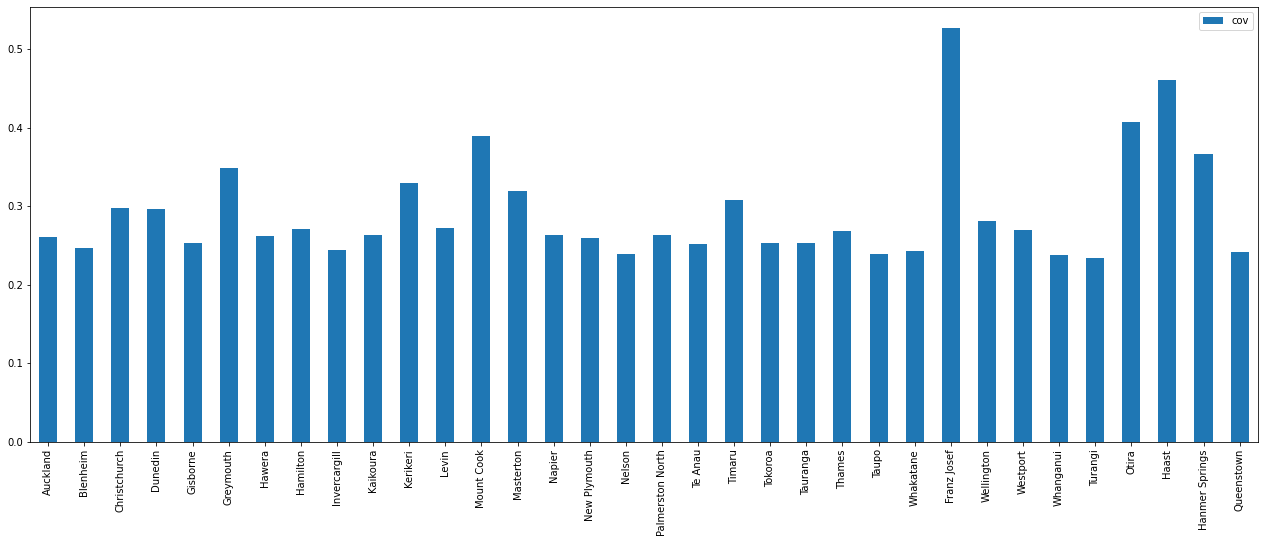

In [40]:
figsize = (22,8)
fig,ax = plt.subplots(1,1,figsize=figsize)
gdf.plot.bar(y='cov',ax=ax)